<a href="https://colab.research.google.com/github/vladimir-shvets/C-projects/blob/master/ex05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision II - Exercise 5

## Preparation

- Mount my Google Drive
- Set working directory
- Import libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/CV2/Exercises/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/CV2/Exercises


In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 27 19:24:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
import imageio

## 1. Encoder-decoder network for saliency prediction

### Compara the weights provided from Moodle and from torchvision.models

The architecture of convolutional network and the value of parameters are the same. 

The only difference is that `vgg16-conv.pth` is a ordered dict where key represents the name of each parameter, and value is the weights/bias tensor.

To load parameters from `vgg16-conv.pth` is ugly since we have to place weights and bias to corresponding layers. Therefore, I decided to directly use the pre-trained vgg16 from torchvision `torchvision.models.vgg16(pretrained=True)`. Note that we only need the convolutional part (`vgg16.features`) of vgg16. In other words, we need to remove average pooling layer and classifer layers from vgg16, and their corresponding parameters.


In [10]:
vgg16_conv = torch.load('vgg16-conv.pth')
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
torch.equal(vgg16_conv['conv1_1_weight'], next(iter(vgg16.parameters())))

True

### 1.1 Encoder

What is the shape of the output of layer **conv5_3**?

16 x 512 x 3 x 3

### Option 2

In [12]:
vgg16 = torchvision.models.vgg16(pretrained=True)

for param in vgg16.parameters(): 
  param.requires_grad = False

encoder = vgg16.features[:-1]

### 1.2 Decoder

In [13]:
decoder = nn.Sequential(
          nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
          nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
          nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

          nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
          nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
          nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

          nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
          nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
          nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

          nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
          nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

          nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
          nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
          nn.Conv2d(64, 1, 1, padding=0)
        )

### 1.3 Encoder-Decoder

In [14]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    # self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    # x = self.sigmoid(x)
    return x 

## 2. Loss functions for saliency prediction

In [15]:
class BCELossWithDownsampling():
  def __init__(self):
    self.downsample = nn.AvgPool2d(4, stride=4, count_include_pad=False)
    self.loss_fn = nn.BCEWithLogitsLoss()

  def __call__(self, pred, y):
    return self.loss_fn(self.downsample(pred), self.downsample(y))

## 3. Training the encoder-decoder network

### Data pre-processing

In [16]:
def read_file(filename):
	lines = []
	with open(filename, 'r') as file:
	    for line in file: 
	        line = line.strip() #or some other preprocessing
	        lines.append(line)
	return lines

class FixationDataset(Dataset):
	def __init__(self, root_dir, image_file, fixation_file, transform=None):
		self.root_dir = root_dir
		self.image_files = read_file(image_file)
		self.fixation_files = read_file(fixation_file)
		self.transform = transform
		assert(len(self.image_files) == len(self.fixation_files))

	def __len__(self):
		return len(self.image_files)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()
	 
		img_name = os.path.join(self.root_dir, self.image_files[idx])
		image = imageio.imread(img_name)

		fix_name = os.path.join(self.root_dir, self.fixation_files[idx])
		fix = imageio.imread(fix_name)

		sample = {'image': image, 'fixation': fix}

		if self.transform:
			sample = self.transform(sample)

		return sample

class Rescale():
    '''Recaling data'''
    def __init__(self):
        pass
    def __call__(self, sample):
        image, fixation = sample['image'], sample['fixation']
        image = image.astype(np.float32) / 255.0
        fixation = fixation.astype(np.float32) / 255.0
        return {'image': image, 'fixation': fixation}

class ToTensor():
    '''Convert data to a tensor'''
    def __init__(self):
        pass
    def __call__(self, sample):
        image, fixation = sample['image'], sample['fixation']
        image = torch.from_numpy(np.transpose(image))
        fixation = torch.from_numpy(np.expand_dims(fixation, axis=0))
        return {'image': image, 'fixation': fixation}

class Normalize():
    '''Normalize tensor'''
    def __init__(self):
        pass
    def __call__(self, sample):
        image, fixation = sample['image'], sample['fixation']
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return {'image': normalize(image), 'fixation': fixation}

### Training step

In [17]:
def get_dl(bs=16):
    transform = torchvision.transforms.Compose([Rescale(), ToTensor(), Normalize()])
    train_ds = FixationDataset('cv2_training_data', 'cv2_training_data/train_images.txt', 'cv2_training_data/train_fixations.txt', transform)
    valid_ds = FixationDataset('cv2_validation_data', 'cv2_validation_data/val_images.txt', 'cv2_validation_data/val_fixations.txt', transform)

    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
    return train_dl, valid_dl

In [25]:
def fit(train_dl, valid_dl, model, loss_fn, opt, num_epoch):
  for epoch in range(num_epoch):
    print("training")
    model.train()
    train_loss = 0;
    for batch in train_dl:
      
      pred = model(batch['image'].to(device))
      loss = loss_fn(pred, batch['fixation'].to(device))
      train_loss += loss

      loss.backward()
      opt.step()
      opt.zero_grad()
    train_loss /= len(train_dl)

    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_fn(model(batch['image'].to(device)), batch['fixation'].to(device)) for batch in valid_dl)
    valid_loss /= len(valid_dl)
    print(f'Epoch {epoch: 2d}, training loss = {train_loss: .4f}, validation loss = {valid_loss: .4f}') 
    
    if epoch == num_epoch-1:
      PATH = f'autoencoder_epoch_Exercise5_{epoch}_Adam_1e-4.ckpt'
      torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'train_loss': train_loss,
                'valid_loss': valid_loss
                  }, PATH)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Generator().to(device)
loss_fn = BCELossWithDownsampling()
opt = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)
# opt = torch.optim.SGD(model.parameters(), lr=1e-2) 
train_dl, valid_dl = get_dl()

In [27]:
# train
fit(train_dl, valid_dl, model, loss_fn, opt, 15)

training
Epoch  0, training loss =  0.2552, validation loss =  0.2321
training
Epoch  1, training loss =  0.2375, validation loss =  0.2247
training
Epoch  2, training loss =  0.2287, validation loss =  0.2230
training
Epoch  3, training loss =  0.2161, validation loss =  0.2278
training
Epoch  4, training loss =  0.2004, validation loss =  0.2323
training
Epoch  5, training loss =  0.1850, validation loss =  0.2426
training
Epoch  6, training loss =  0.1747, validation loss =  0.2462
training
Epoch  7, training loss =  0.1672, validation loss =  0.2517
training
Epoch  8, training loss =  0.1626, validation loss =  0.2432
training
Epoch  9, training loss =  0.1605, validation loss =  0.2445
training
Epoch  10, training loss =  0.1586, validation loss =  0.2572
training
Epoch  11, training loss =  0.1565, validation loss =  0.2620
training
Epoch  12, training loss =  0.1550, validation loss =  0.2640
training
Epoch  13, training loss =  0.1541, validation loss =  0.2631
training
Epoch  

# Load Model

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Generator().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-4,weight_decay=1e-4) 
checkpoint = torch.load('autoencoder_epoch_Exercise59.ckpt')


model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch_backup = checkpoint['epoch']
train_loss_backup = checkpoint['train_loss']
valid_loss_backup = checkpoint['valid_loss']

# Visualizaiton

## generator

In [30]:
import os 
from sklearn.utils import shuffle

imgs_train_path = 'cv2_training_data/images/train'
maps_train_path = 'cv2_training_data/fixations/train'

imgs_val_path = 'cv2_validation_data/images/validation/'
maps_val_path = 'cv2_validation_data/fixations/validation/'



def generator(b_s, phase_gen='train'):
    if phase_gen == 'train':
        images = [imgs_train_path + f for f in os.listdir(imgs_train_path) if f.endswith('.png')]
        maps = [maps_train_path + f for f in os.listdir(maps_train_path) if f.endswith('.png')]
    elif phase_gen == 'val':
        images = [imgs_val_path + f for f in os.listdir(imgs_val_path) if f.endswith('.png')]
        maps = [maps_val_path + f for f in os.listdir(maps_val_path) if f.endswith('.png')]
    else:
        raise NotImplementedError

    images.sort()
    maps.sort()
    
    images , maps = shuffle(images,maps)
    
    counter = 0
    
    while True:
        yield preprocess_images(images[counter:counter + b_s], shape_r, shape_c), preprocess_maps(maps[counter:counter + b_s], shape_r_gt, shape_c_gt)
        if counter + b_s >= len(images):
          break
        counter = counter + b_s

def preprocess_images(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), shape_r, shape_c, 3))

    for i, path in enumerate(paths):
        original_image = cv2.imread(path)
        padded_image = padding(original_image, shape_r, shape_c, 3)
        ims[i] = padded_image.astype('float')
    
#     cv2 : BGR
#     PIL : RGB
    ims = ims[...,::-1]
    ims /= 255.0
    ims = np.rollaxis(ims, 3, 1)  
    return ims


def preprocess_maps(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), 1, shape_r, shape_c))

    for i, path in enumerate(paths):
        original_map = cv2.imread(path, 0)
        padded_map = padding(original_map, shape_r, shape_c, 1)
        ims[i, 0] = padded_map.astype(np.float32)
        ims[i, 0] /= 255.0
        
    return ims

def padding(img, shape_r=224, shape_c=224, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels) , dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)

    original_shape = img.shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded

Original
(224, 224, 3)


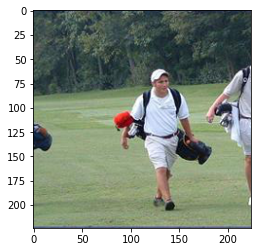

predicted
[[10.549231    3.9040349   2.3875997  ...  2.79248     4.2827706
  10.897677  ]
 [ 4.2489095   0.8069878   0.35210863 ...  0.46363133  0.94814974
   4.427632  ]
 [ 2.8675768   0.40259176  0.1471457  ...  0.21079962  0.49990243
   3.0342565 ]
 ...
 [ 3.8576348   0.6879092   0.29840147 ...  0.4294933   0.85468847
   4.094667  ]
 [ 5.623606    1.3342898   0.68149495 ...  0.8845195   1.5490236
   5.820167  ]
 [12.87227     5.5469284   3.7825718  ...  4.339006    5.968296
  12.963136  ]]


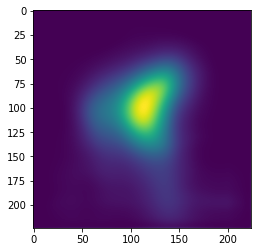

Original


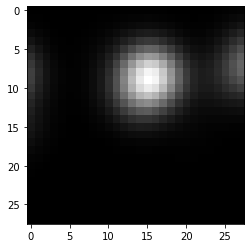

Original
(224, 224, 3)


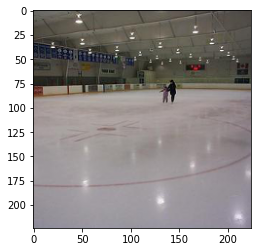

predicted
[[11.009342    4.2245355   2.6534064  ...  2.2695265   3.6613643
   9.993696  ]
 [ 4.583459    0.9267265   0.42332944 ...  0.32193813  0.7186808
   3.7905421 ]
 [ 3.1606426   0.4805805   0.18621498 ...  0.13154966  0.34930804
   2.479903  ]
 ...
 [ 3.3448758   0.5280902   0.20792824 ...  0.37826705  0.77475
   3.8727696 ]
 [ 5.065107    1.0981084   0.52203065 ...  0.8095638   1.4466802
   5.59987   ]
 [12.17611     4.992843    3.2734642  ...  4.1426935   5.759414
  12.708071  ]]


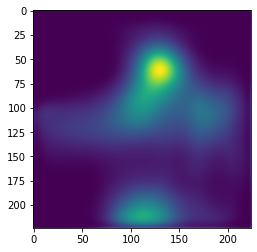

Original


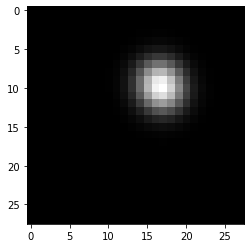

Original
(224, 224, 3)


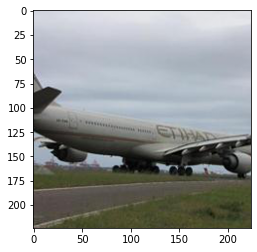

predicted
[[11.843189    4.839492    3.188398   ...  2.408228    3.8360703
  10.260309  ]
 [ 5.230429    1.1814823   0.586839   ...  0.35632327  0.7787209
   3.9691007 ]
 [ 3.7639642   0.66206145  0.28636146 ...  0.14905612  0.38567033
   2.6256075 ]
 ...
 [ 3.3799715   0.539885    0.2156173  ...  0.28222284  0.62280613
   3.430254  ]
 [ 5.095475    1.1127603   0.5341138  ...  0.6480468   1.2256671
   5.108746  ]
 [12.20827     5.023719    3.3100753  ...  3.6636796   5.256863
  12.0888405 ]]


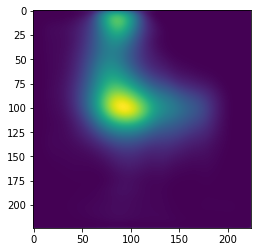

Original


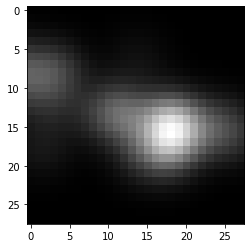

Original
(224, 224, 3)


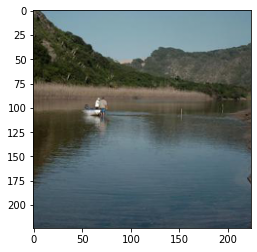

predicted
[[10.885317    4.1398573   2.5866275  ...  2.7808516   4.269435
  10.879084  ]
 [ 4.4930935   0.8947354   0.4051274  ...  0.4594401   0.94169044
   4.410834  ]
 [ 3.082337    0.45986238  0.1762663  ...  0.2075367   0.49404305
   3.0143065 ]
 ...
 [ 4.8731155   1.0523313   0.5228439  ...  0.20644861  0.49258277
   3.0091224 ]
 [ 6.6764593   1.8255739   1.0309535  ...  0.51373106  1.0298462
   4.6374445 ]
 [14.102803    6.5703      4.733661   ...  3.2277944   4.782172
  11.476732  ]]


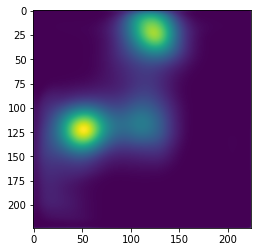

Original


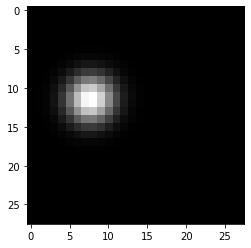

Original
(224, 224, 3)


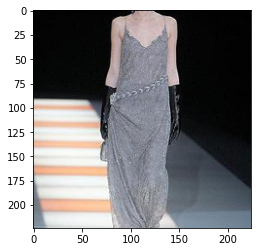

predicted
[[11.316218    4.451415    2.8552482  ...  2.6225624   4.085339
  10.618297  ]
 [ 4.81856     1.0180527   0.48256606 ...  0.41435733  0.87097067
   4.2225327 ]
 [ 3.3793545   0.54469025  0.22162628 ...  0.18155552  0.44647655
   2.8478184 ]
 ...
 [ 3.4969623   0.57355237  0.23283881 ...  0.20891449  0.49720594
   3.0253    ]
 [ 5.222654    1.1628115   0.5648106  ...  0.51850486  1.0373727
   4.656787  ]
 [12.368209    5.143714    3.4111073  ...  3.2445853   4.801707
  11.503181  ]]


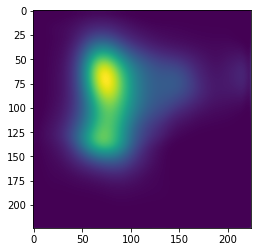

Original


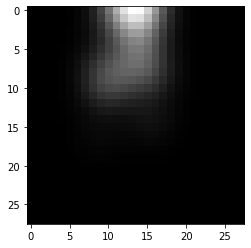

Original
(224, 224, 3)


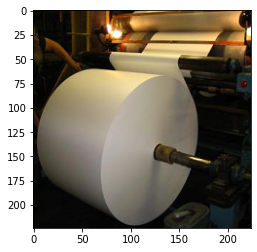

predicted
[[11.060993    4.2582855   2.6775658  ...  2.4411883   3.8702424
  10.305973  ]
 [ 4.6214123   0.93964374  0.43000966 ...  0.36538452  0.7917347
   4.0028443 ]
 [ 3.1938195   0.4890409   0.18990971 ...  0.15439692  0.39483932
   2.6576717 ]
 ...
 [ 3.5356991   0.5850656   0.23897606 ...  0.18593279  0.45547226
   2.8804595 ]
 [ 5.2739697   1.1836202   0.5781118  ...  0.47566387  0.9722557
   4.491589  ]
 [12.439428    5.1984935   3.4590561  ...  3.0957649   4.635669
  11.282629  ]]


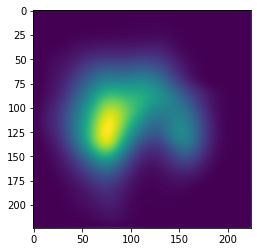

Original


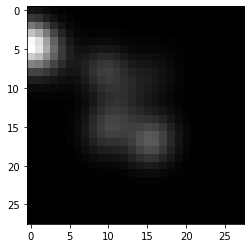

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# how many pic you want to visualiz at randomly
no_visual = 5
shape_r = 224
shape_c = 224

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

# test
# scores = np.array([ -0.54761371,  17.04850603,   4.86054302])
# print(sigmoid_v(scores))

shape_r_gt = 28
shape_c_gt = 28

visual_cnt = 0
for i,gt_map in generator(1,phase_gen='val'):
    print ("Original")
    org_image = i[0].copy()
    
    org_image = np.rollaxis(org_image, 0, 3) 
    print (org_image.shape)
    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    out = torch.sigmoid(model.forward(i))
    # adding term which were subtracted at pre processing
    plt.imshow(org_image)
    plt.show()
    print ("predicted")
    a = ((out[0]).squeeze(0).data.cpu().numpy())
    print(a*255.0)
    plt.imshow(a*255.0)
    plt.show()
    print ("Original")
    plt.imshow(gt_map[0][0],cmap='gray')
    plt.show()
    visual_cnt += 1
    if visual_cnt > no_visual:
      break